# Generalized Lasso examples

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 1

In [2]:
def show_plot(coef, value, coef_expected = None, value_expected = None, suptitle=None):
    # Plot signal and result
    
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1)
    plt.plot(coef, label='original')
    if coef_expected is not None:
        plt.plot(coef_expected, label='expected')    
    plt.title('coeficients')
    plt.legend()
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(value, label='original')
    if value_expected is not None:
        plt.plot(value_expected, label='expected')        
    
    plt.title('value')
    plt.legend()
    plt.grid()
    
    if suptitle is not None:
        plt.suptitle(suptitle)    

    plt.tight_layout()    
    if suptitle is not None:
        plt.subplots_adjust(top=0.85)

In [3]:
# fix the seed of random
np.random.seed(0)

## Fused Lasso

Compare effectiveness of regularization parameter L1 and L2.

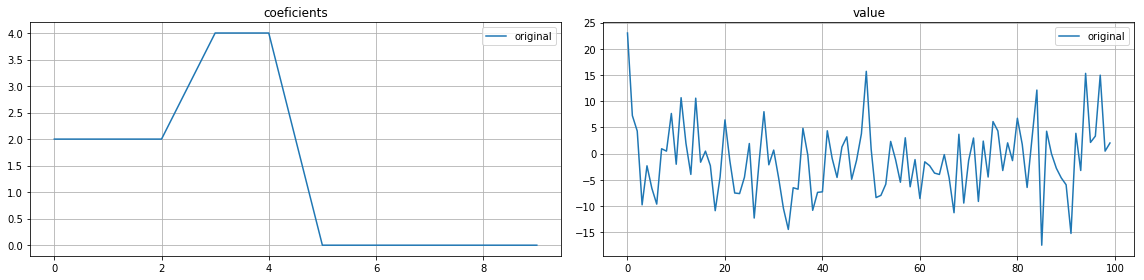

In [4]:
# input signals

n_samples = 100
n_features = 10
beta = np.zeros(n_features)
beta[0:3] = 2
beta[3:5] = 4

X = np.random.normal(0.0, 1.0, (n_samples, n_features))
y = X.dot(beta) + np.random.normal(0, 0.5)
show_plot(beta, y)

In [5]:
def _soft_threshold(X: np.ndarray, thresh: float) -> np.ndarray:
    return np.where(np.abs(X) <= thresh, 0, X - thresh * np.sign(X))    

def glasso_admm(y, X, D, l):
    n_samples, n_features = X.shape
    beta = X.T.dot(y) / n_samples
    gamma = beta.copy()

    p = 0.5
    threshold = l / p    
    u = np.ones(beta.shape)
    
    inv_matrix = np.linalg.inv(X.T.dot(X) + n_samples*p*D.T.dot(D))
    for i in range(1000):
        beta = inv_matrix.dot(X.T.dot(y) + n_samples*p*D.T.dot(gamma - u/p))
        gamma = _soft_threshold(D.dot(beta)+u/p, threshold)
        u += p*(D.dot(beta) - gamma)
    
    return beta, gamma

In [6]:
def run_fused_lasso(l1, l2):
    
    D_fused = np.eye(n_features) - np.eye(n_features+1)[:-1, 1:]
    D_fused[0, 0] = 0
    D = l1 * np.eye(n_features) + l2 * D_fused    
    
    l = 1

    glasso_beta, glasso_gamma = glasso_admm(y, X, D, l)
    glasso_signal = np.linalg.pinv(D).dot(glasso_gamma)
    glasso_predict = X.dot(glasso_signal)
    
    # Plot signal and result
    show_plot(beta, y, glasso_signal, glasso_predict, 'L1={0} and L2={1}'.format(l1, l2))
    return np.linalg.norm(y - glasso_predict), glasso_signal

45.14247775535978
[ 0.53723586  0.56663166  0.59693877  2.56189189  2.56189189 -1.37870674
 -1.37870674 -1.37870674 -1.36556473 -1.32290511]
CPU times: user 212 ms, sys: 9.47 ms, total: 221 ms
Wall time: 227 ms


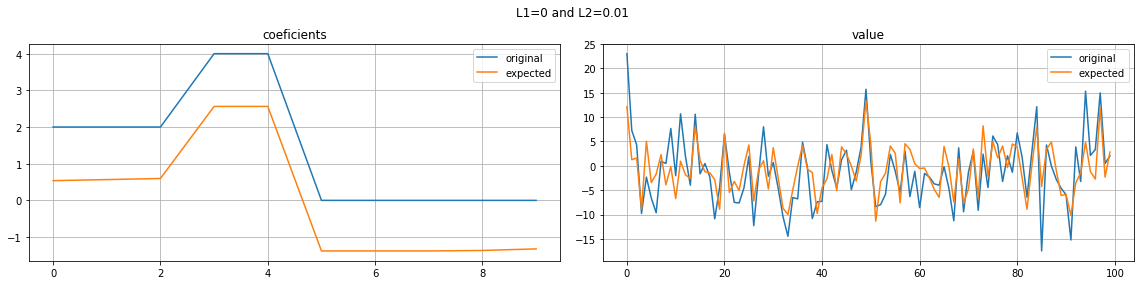

In [7]:
%%time

error, coef = run_fused_lasso(0, 0.01)
print(error)
print(coef)

3.6646994037080396
[1.86120556e+00 1.87621265e+00 1.87484570e+00 3.88472588e+00
 3.89107198e+00 1.19282467e-01 1.08438607e-02 9.85805514e-04
 8.96186831e-05 8.14715301e-06]
CPU times: user 171 ms, sys: 8.8 ms, total: 179 ms
Wall time: 182 ms


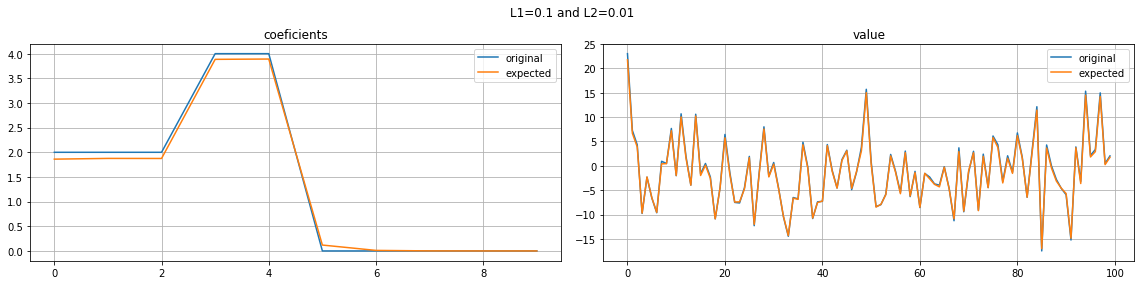

In [8]:
%%time

error, coef = run_fused_lasso(0.1, 0.01)
print(error)
print(coef)

3.448037172310199
[1.84433207 1.88220907 1.89121627 3.89325485 3.89299195 0.
 0.         0.         0.         0.        ]
CPU times: user 174 ms, sys: 10.7 ms, total: 185 ms
Wall time: 182 ms


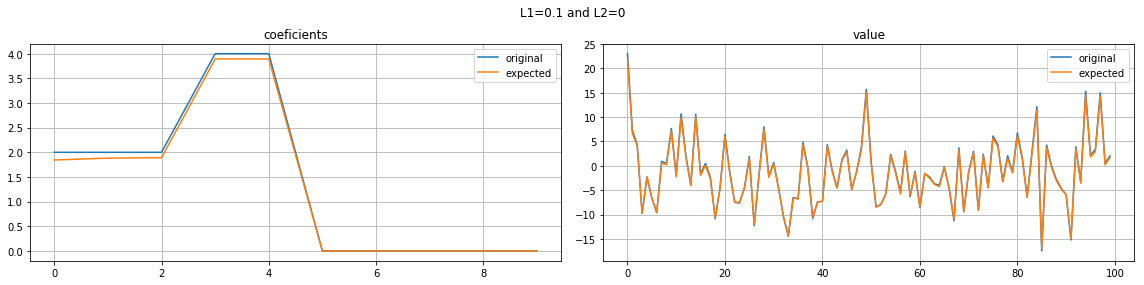

In [9]:
%%time

error, coef = run_fused_lasso(0.1, 0)
print(error)
print(coef)